# Análisis de Amenazas: STRIDE + MITRE ATT&CK
## Dataset: Cybersecurity Intrusion Detection

**Objetivo**: Realizar modelado de amenazas aplicando frameworks STRIDE y MITRE ATT&CK al dataset de detección de intrusiones de ciberseguridad, generando IoCs calculables y una matriz de amenazas.

## Metodología de Análisis de Amenazas

### **STRIDE: Categorización de Amenazas**
Framework que clasifica las amenazas en 6 categorías principales:
- **S**poofing: Suplantación de identidad
- **T**ampering: Manipulación de datos
- **R**epudiation: Negación de acciones
- **I**nformation Disclosure: Filtración de información
- **D**enial of Service: Bloqueo de servicios
- **E**levation of Privilege: Aumento de permisos

**¿Para qué?** Organizar y entender qué tipo de amenaza se enfrenta.

---

### **MITRE ATT&CK: Técnicas de Ataque Reales**
Base de datos que mapea las amenazas a técnicas específicas usadas por atacantes reales.

**Ejemplo:**
- STRIDE dice: "Esto es un Spoofing"
- MITRE dice: "Específicamente, es T1110 - Brute Force"

**¿Para qué?** Identificar exactamente qué técnica está usando el atacante y cómo responder.

---

### **IoC: Indicadores de Compromiso**
Señales en tus datos que indican que algo malo está pasando.

**Ejemplo:** "Más de 5 intentos de login fallidos en 1 minuto" = Posible ataque de fuerza bruta.

**¿Para qué?** Detectar amenazas analizando patrones específicos en tus datos.

---

In [16]:
# Importaciones y Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Librerías cargadas correctamente")
print("Configuración de visualización aplicada")

Librerías cargadas correctamente
Configuración de visualización aplicada


## Carga y Exploración del Dataset

Cargamos el dataset completo para realizar el análisis de amenazas.

In [17]:
from pathlib import Path
import kagglehub
import shutil
import pandas as pd

# Definir rutas del proyecto
RAW_DIR = Path("data/raw")
PROCESSED_DIR = Path("data/processed")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Dataset en Kaggle
dataset_name = "dnkumars/cybersecurity-intrusion-detection-dataset"
local_file = PROCESSED_DIR / "dataset_complete.csv"

if local_file.exists():
    print("Dataset ya existe localmente, no es necesario descargar.")
else:
    try:
        dataset_path = kagglehub.dataset_download(dataset_name)
        src = Path(dataset_path)
        if not src.exists():
            raise FileNotFoundError(f"Dataset no encontrado en {src}")

        # Buscar el archivo CSV dentro del dataset descargado
        csv_files = list(src.rglob("*.csv"))
        if not csv_files:
            raise FileNotFoundError("No se encontraron archivos CSV en el dataset")
        
        # Usar el primer archivo CSV encontrado
        source_csv = csv_files[0]
        
        # Copiar a carpeta PROCESSED_DIR con nombre estándar
        shutil.copy2(source_csv, local_file)
        
        # Limpiar archivos temporales
        shutil.rmtree(src)

    except Exception as e:
        print(f"Error al descargar: {e}")


# Cargar el Dataset
df = pd.read_csv(local_file)

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")

print("\nColumnas disponibles:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Dataset ya existe localmente, no es necesario descargar.
Dataset cargado: 9537 registros, 11 columnas

Columnas disponibles:
 1. session_id
 2. network_packet_size
 3. protocol_type
 4. login_attempts
 5. session_duration
 6. encryption_used
 7. ip_reputation_score
 8. failed_logins
 9. browser_type
10. unusual_time_access
11. attack_detected


## Análisis Exploratorio Orientado a Seguridad

Realizamos un EDA enfocado en identificar patrones que puedan indicar amenazas.


Distribución de Ataque Detectado:
attack_detected
0    5273
1    4264
Name: count, dtype: int64


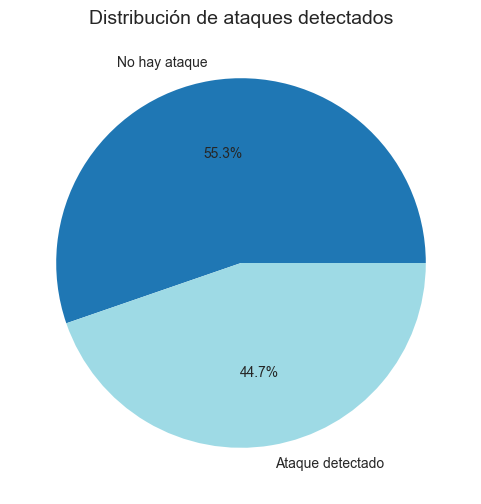


Tasa de Ataque por Protocolo:
               Total_Sesiones  Ataques  Tasa_Ataque
protocol_type                                      
UDP                      2406     1092         45.4
TCP                      6624     2963         44.7
ICMP                      507      209         41.2


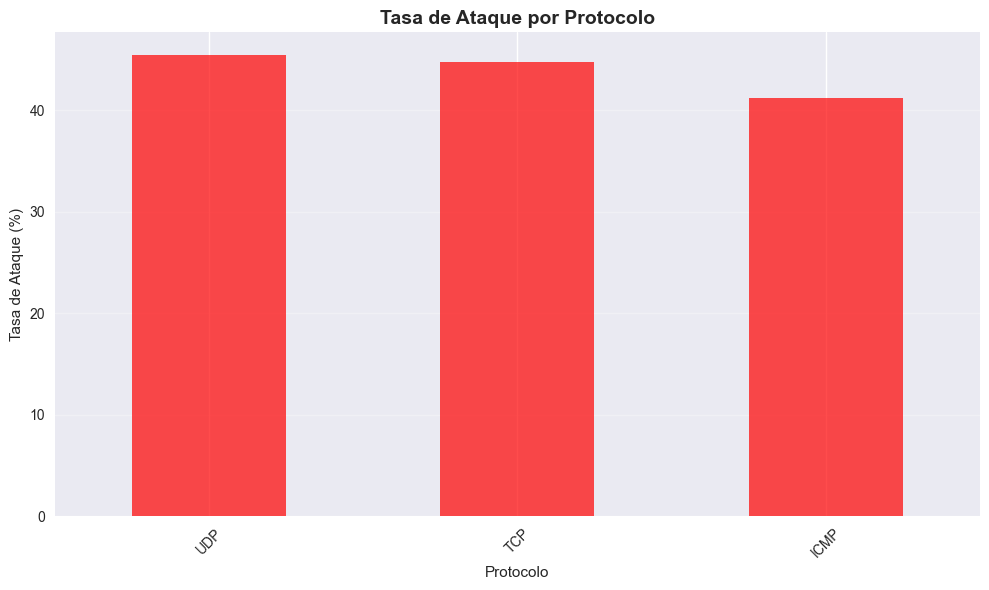


Tasa de Ataque por Tipo de Encriptación:
                 Total_Sesiones  Ataques  Tasa_Ataque
encryption_used                                      
None                       1966      910         46.3
DES                        2865     1299         45.3
AES                        4706     2055         43.7


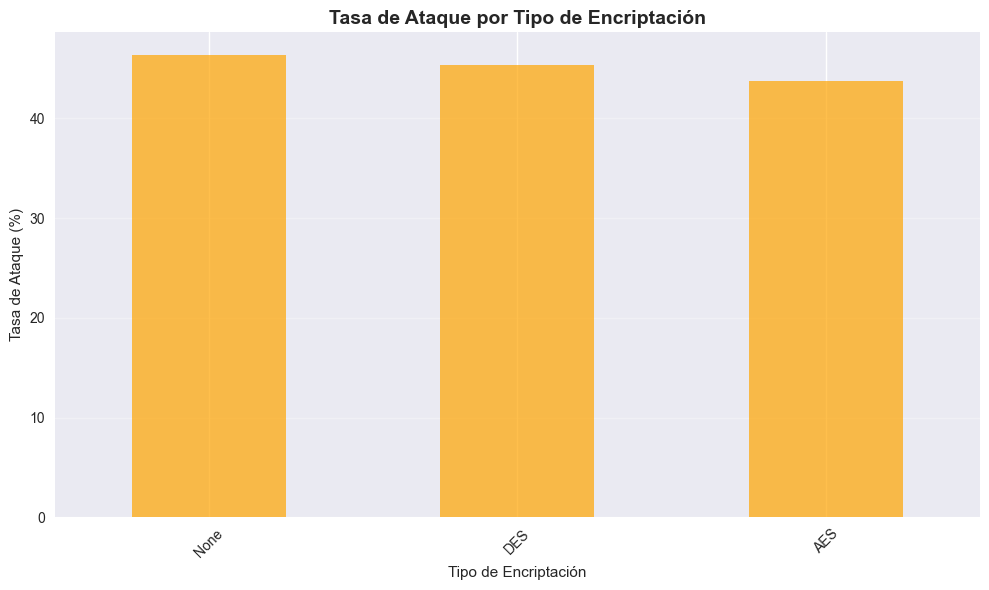


Tasa de Ataque por Tipo de Navegador:
              Total_Sesiones  Ataques  Tasa_Ataque
browser_type                                      
Unknown                  502      367         73.1
Edge                    1469      643         43.8
Firefox                 1944      849         43.7
Chrome                  5137     2202         42.9
Safari                   485      203         41.9


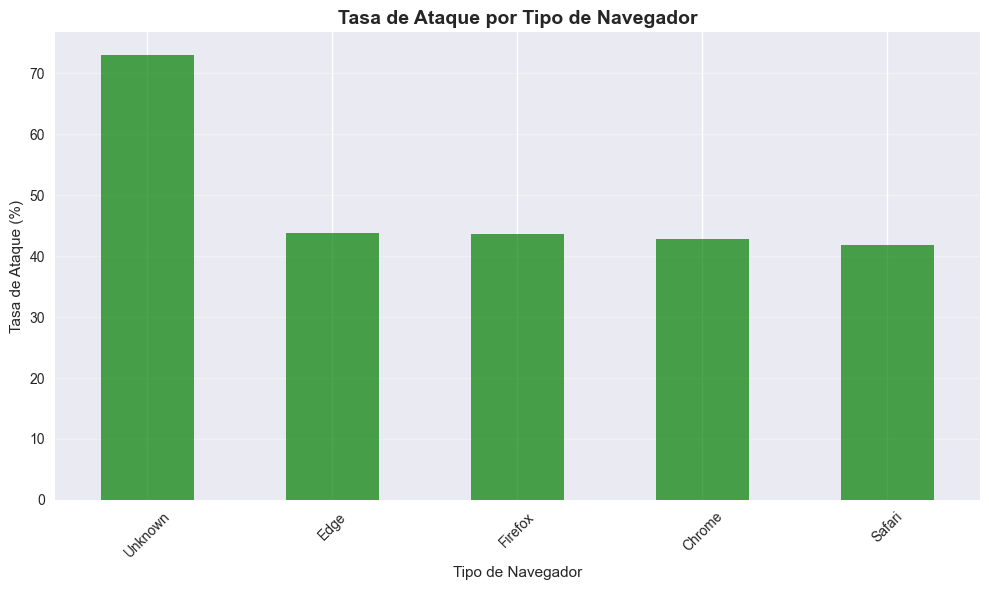

,Total_Sesiones,Ataques,Tasa_Ataque
browser_type,,,
Unknown,502,367,73.1
Edge,1469,643,43.8
Firefox,1944,849,43.7
Chrome,5137,2202,42.9
Safari,485,203,41.9


In [31]:
# Función para calcular tasa de ataque
def calculate_attack_rate(df, group_col, target_col='attack_detected'):
    rates = df.groupby(group_col)[target_col].agg(['count', 'sum', 'mean']).round(3)
    rates.columns = ['Total_Sesiones', 'Ataques', 'Tasa_Ataque']
    rates['Tasa_Ataque'] *= 100
    return rates.sort_values('Tasa_Ataque', ascending=False)

# Función para análisis y gráfico
def analyze_attack_rate(df, group_col, title, color, target_col='attack_detected'):
    rates = calculate_attack_rate(df, group_col, target_col)
    print(f"\nTasa de Ataque por {title}:")
    print(rates)

    plt.figure(figsize=(10, 6))
    rates['Tasa_Ataque'].plot(kind='bar', color=color, alpha=0.7)
    plt.title(f'Tasa de Ataque por {title}', fontsize=14, fontweight='bold')
    plt.xlabel(title)
    plt.ylabel('Tasa de Ataque (%)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    return rates

# Distribución de ataques detectados
print("\nDistribución de Ataque Detectado:")
threat_counts = df["attack_detected"].value_counts()
print(threat_counts)

threat_labels = {0: "No hay ataque", 1: "Ataque detectado"}
threat_counts_labeled = threat_counts.rename(threat_labels)

plt.figure(figsize=(6, 6))
threat_counts_labeled.plot(
    kind='pie',
    autopct='%1.1f%%',
    cmap="tab20",
    ylabel=''
)
plt.title("Distribución de ataques detectados", fontsize=14)
plt.show()

# Normalizar valores faltantes en encryption_used
df['encryption_used'] = df['encryption_used'].fillna('None')

# Llamadas genéricas
analyze_attack_rate(df, 'protocol_type', "Protocolo", "red")
analyze_attack_rate(df, 'encryption_used', "Tipo de Encriptación", "orange")
analyze_attack_rate(df, 'browser_type', "Tipo de Navegador", "green")

## Matriz de Amenazas: STRIDE + MITRE ATT&CK

| Feature (Dataset) | STRIDE (Categoría) | Amenaza Detectada | MITRE ATT&CK (Técnica) | Descripción |
|-------------------|-------------------|-------------------|------------------------|-------------|
| `failed_logins` | Spoofing | Credential Stuffing / Brute Force | T1110 - Brute Force | Intentos masivos de autenticación fallida |
| `encryption_used` | Information Disclosure | Tráfico sin cifrar interceptado | T1040 - Network Sniffing | Comunicaciones no cifradas susceptibles a interceptación |
| `network_packet_size` | Information Disclosure | Exfiltración de datos | T1041 - Exfiltration Over C2 | Transferencia anómala de datos hacia el exterior |
| `protocol_type` | Denial of Service | Flood de paquetes / Protocol Abuse | T1499 - Endpoint DoS | Uso anómalo de protocolos para sobrecarga del sistema |
| `login_attempts` | Tampering | Reconnaissance / Account Discovery | T1087 - Account Discovery | Escaneo masivo de intentos de acceso |
| `session_duration` | Tampering | Session Hijacking / Persistence | T1078 - Valid Accounts | Sesiones anómalamente largas o cortas |
| `ip_reputation_score` | Spoofing | IP Spoofing / Malicious Sources | T1078 - Valid Accounts | Acceso desde fuentes de baja reputación |
| `browser_type` | Spoofing | User Agent Spoofing | T1078 - Valid Accounts | Suplantación de identidad del navegador |
| `unusual_time_access` | Spoofing | Account Takeover / Temporal Anomaly | T1078 - Valid Accounts | Acceso en horarios inusuales o imposibles |

- **Total de Features Analizados**: `10`  
- **Features Mapeados a Amenazas**: `9`

---

### Distribución STRIDE
| Categoría STRIDE           | # Amenazas | Ejemplo Detectado                  |
|-----------------------------|------------|-------------------------------------|
| Spoofing                | 5          | Brute Force, IP Spoofing, User Agent Spoofing, Temporal Anomaly, Session Hijacking |
| Tampering               | 2          | Account Discovery, Session Hijacking |
| Information Disclosure   | 2          | Exfiltración de datos, Tráfico sin cifrar |
| Denial of Service        | 1          | Protocol Abuse / DoS por paquetes |
| Repudiation              | 0          | -                                   |
| Elevation of Privilege   | 0          | -                                   |

---

### Distribución MITRE ATT&CK
| Táctica ATT&CK            | Técnicas Detectadas | # Técnicas |
|----------------------------|----------------------|------------|
| Initial Access             | -                    | 0          |
| Execution                  | -                    | 0          |
| Persistence                | -                    | 0          |
| Privilege Escalation       | -                    | 0          |
| Defense Evasion            | -                    | 0          |
| Credential Access          | T1110 (Brute Force)  | 1          |
| Discovery                  | T1087 (Account Discovery) | 1     |
| Lateral Movement           | -                    | 0          |
| Collection                 | -                    | 0          |
| Command & Control          | T1041 (Exfiltration Over C2) | 1  |
| Exfiltration               | T1041 (Exfiltration Over C2) | 1  |
| Impact                     | T1499 (DoS) | 1 |
| Resource Development       | -                    | 0          |

---

## Definición de Reglas IoC (Indicadores de Compromiso)

Definimos las reglas de detección basadas en STRIDE y MITRE ATT&CK, mapeándolas a features calculables del dataset.

### **Estructura de una Regla IoC**

Cada regla IoC se compone de **7 elementos clave**:

```python
"feature_name": {
    "description": "Descripción de la amenaza",
    "mitre": "Código MITRE ATT&CK",
    "stride": "Categoría STRIDE",
    "calculation": "Cómo calcular el IoC",
    "threshold": "Umbral numérico",
    "window": "Ventana de tiempo (opcional)",
    "percentile": "Percentil para outliers (opcional)"
}
```

---

## **Explicación de cada Componente**

### **1. `description` - Descripción de la Amenaza**
**¿Qué es?** Explicación clara de qué tipo de ataque representa.

**Ejemplo:**
```python
"description": "Credential Stuffing / Brute Force"
```
**Significa:** Ataque de fuerza bruta o reutilización de credenciales comprometidas.

---

### **2. `mitre` - Código MITRE ATT&CK**
**¿Qué es?** Identificador estándar de la técnica de ataque.

**Ejemplo:**
```python
"mitre": "T1110 - Brute Force"
```
**Significa:** Técnica T1110 del framework MITRE ATT&CK, específicamente "Brute Force".

---

### **3. `stride` - Categoría STRIDE**
**¿Qué es?** Clasificación según el modelo de amenazas STRIDE.

**Ejemplo:**
```python
"stride": "Spoofing"
```
**Significa:** Esta amenaza pertenece a la categoría "Spoofing" (suplantación de identidad).

---

### **4. `calculation` - Cómo Calcular el IoC**
**¿Qué es?** Instrucciones específicas para detectar la amenaza.

**Ejemplo:**
```python
"calculation": ">5 intentos en <1 min por dispositivo"
```
**Significa:** Marcar como amenaza si hay más de 5 intentos fallidos en menos de 1 minuto.

---

### **5. `threshold` - Umbral Numérico**
**¿Qué es?** Valor límite que activa la detección.

**Ejemplo:**
```python
"threshold": 5
```
**Significa:** El umbral es 5 intentos fallidos.

---

### **6. `window` - Ventana de Tiempo (Opcional)**
**¿Qué es?** Período de tiempo para evaluar el umbral.

**Ejemplo:**
```python
"window": "1min"
```
**Significa:** Evaluar el umbral en una ventana de 1 minuto.

---

### **7. `percentile` - Percentil para Outliers (Opcional)**
**¿Qué es?** Percentil usado para detectar valores anómalos.

**Ejemplo:**
```python
"percentile": 0.95
```
**Significa:** Marcar como amenaza valores que superen el percentil 95 (top 5% de valores).

---

## **Ejemplo Completo de una Regla**

```python
"failed_auth_attempts": {
    "description": "Credential Stuffing / Brute Force",
    "mitre": "T1110 - Brute Force", 
    "stride": "Spoofing",
    "calculation": ">5 intentos en <1 min por dispositivo",
    "threshold": 5,
    "window": "1min"
}
```

**Traducción:**
- **Qué detecta**: Ataques de fuerza bruta
- **Cómo lo categoriza**: Como "Spoofing" (suplantación)
- **Técnica MITRE**: T1110 - Brute Force
- **Cuándo se activa**: Más de 5 intentos fallidos en 1 minuto
- **Umbral**: 5 intentos
- **Ventana**: 1 minuto

---

## **Tipos de Cálculos**

### **1. Umbral Fijo**
```python
"threshold": 1000,
"calculation": ">1000 pkt/s"
```
**Uso:** Para valores que siempre indican amenaza.

### **2. Percentil Dinámico**
```python
"percentile": 0.95,
"calculation": "valores outlier sobre p95"
```
**Uso:** Para valores que varían según el contexto.

### **3. Ventana Deslizante**
```python
"window": "5min",
"calculation": "rolling average >80% sostenido"
```
**Uso:** Para patrones que se desarrollan en el tiempo.

### **4. Combinación de Condiciones**
```python
"calculation": "is_encrypted = 0 + tráfico > umbral"
```
**Uso:** Para amenazas que requieren múltiples condiciones.

In [32]:
# Definir reglas IoC con mapeo STRIDE + MITRE
ioc_rules = {
    "failed_logins": {
        "description": "Credential Stuffing / Brute Force",
        "mitre": "T1110 - Brute Force",
        "stride": "Spoofing",
        "calculation": ">3 intentos fallidos por sesión",
        "threshold": 3,
        "window": "por sesión"
    },
    "encryption_used": {
        "description": "Tráfico sin cifrar interceptado",
        "mitre": "T1040 - Network Sniffing",
        "stride": "Information Disclosure",
        "calculation": "encryption_used = 'None' + tráfico > umbral",
        "threshold": "None",
        "traffic_threshold": None  # Se calculará dinámicamente
    },
    "network_packet_size": {
        "description": "Exfiltración de datos",
        "mitre": "T1041 - Exfiltration Over C2",
        "stride": "Information Disclosure",
        "calculation": "valores outlier sobre p95",
        "percentile": 0.95
    },
    "protocol_type": {
        "description": "Flood de paquetes / Protocol Abuse",
        "mitre": "T1499 - Endpoint DoS",
        "stride": "Denial of Service",
        "calculation": "ICMP > 50% + packet_size > p95",
        "threshold": 0.5,
        "percentile": 0.95
    },
    "login_attempts": {
        "description": "Reconnaissance / Account Discovery",
        "mitre": "T1087 - Account Discovery",
        "stride": "Tampering",
        "calculation": ">5 intentos por sesión",
        "threshold": 5,
        "window": "por sesión"
    },
    "session_duration": {
        "description": "Session Hijacking / Persistence",
        "mitre": "T1078 - Valid Accounts",
        "stride": "Tampering",
        "calculation": "duración outlier sobre p95 o < p5",
        "percentile": 0.95,
        "window": "rolling 1h"
    },
    "ip_reputation_score": {
        "description": "IP Spoofing / Malicious Sources",
        "mitre": "T1078 - Valid Accounts",
        "stride": "Spoofing",
        "calculation": "score < 0.3 (baja reputación)",
        "threshold": 0.3,
        "window": "por sesión"
    },
    "browser_type": {
        "description": "User Agent Spoofing",
        "mitre": "T1078 - Valid Accounts",
        "stride": "Spoofing",
        "calculation": "browser_type = 'Unknown' + otros indicadores",
        "threshold": "Unknown",
        "window": "por sesión"
    },
    "unusual_time_access": {
        "description": "Account Takeover / Temporal Anomaly",
        "mitre": "T1078 - Valid Accounts",
        "stride": "Spoofing",
        "calculation": "unusual_time_access = 1 + otros indicadores",
        "threshold": 1,
        "window": "por sesión"
    }
}

print(f"{len(ioc_rules)} reglas IoC definidas")
print("Reglas definidas:")
for feature, rule in ioc_rules.items():
    print(f"  • {feature}: {rule['description']} ({rule['stride']})")

9 reglas IoC definidas
Reglas definidas:
  • failed_logins: Credential Stuffing / Brute Force (Spoofing)
  • encryption_used: Tráfico sin cifrar interceptado (Information Disclosure)
  • network_packet_size: Exfiltración de datos (Information Disclosure)
  • protocol_type: Flood de paquetes / Protocol Abuse (Denial of Service)
  • login_attempts: Reconnaissance / Account Discovery (Tampering)
  • session_duration: Session Hijacking / Persistence (Tampering)
  • ip_reputation_score: IP Spoofing / Malicious Sources (Spoofing)
  • browser_type: User Agent Spoofing (Spoofing)
  • unusual_time_access: Account Takeover / Temporal Anomaly (Spoofing)


## Cálculo de IoCs Prácticos

Implementamos las reglas de detección para identificar amenazas en el dataset histórico.

**Nota**: Este análisis se realiza sobre datos históricos, pero las reglas 
pueden aplicarse en tiempo real en un sistema de producción.

In [37]:
# Cálculo de IoCs Prácticos

# Crear copia para cálculos
df_ioc = df.copy()

# Regla 1: Fuerza bruta (más de 3 intentos fallidos por sesión)
df_ioc["brute_force_flag"] = df_ioc["failed_logins"] > 3

# Regla 2: Tráfico sin cifrar interceptado
df_ioc["unencrypted_traffic_flag"] = df_ioc["encryption_used"] == "None"

# Regla 3: Exfiltración de datos (tamaño de paquete anómalo)
packet_size_threshold = df_ioc["network_packet_size"].quantile(0.95)
df_ioc["exfiltration_flag"] = df_ioc["network_packet_size"] > packet_size_threshold

# Regla 4: Protocol Abuse / DoS (ICMP con paquetes grandes)
icmp_large_packets = (df_ioc["protocol_type"] == "ICMP") & (df_ioc["network_packet_size"] > packet_size_threshold)
df_ioc["protocol_abuse_flag"] = icmp_large_packets

# Regla 5: Reconnaissance / Account Discovery (múltiples intentos de login)
df_ioc["reconnaissance_flag"] = df_ioc["login_attempts"] > 5

# Regla 6: Session Hijacking / Persistence (duración anómala)
session_duration_threshold_high = df_ioc["session_duration"].quantile(0.95)
session_duration_threshold_low = df_ioc["session_duration"].quantile(0.05)
df_ioc["session_hijacking_flag"] = (
    (df_ioc["session_duration"] > session_duration_threshold_high) | 
    (df_ioc["session_duration"] < session_duration_threshold_low)
)

# Regla 7: IP Spoofing / Malicious Sources (baja reputación)
df_ioc["ip_spoofing_flag"] = df_ioc["ip_reputation_score"] < 0.3

# Regla 8: User Agent Spoofing (navegador desconocido)
df_ioc["user_agent_spoofing_flag"] = df_ioc["browser_type"] == "Unknown"

# Regla 9: Temporal Anomaly / Account Takeover (acceso en horarios inusuales)
df_ioc["temporal_anomaly_flag"] = df_ioc["unusual_time_access"] == 1

# Regla 10: Ataque Complejo de Credenciales (combinación de indicadores)
df_ioc["credential_attack_flag"] = (
    (df_ioc["failed_logins"] > 3) & 
    (df_ioc["login_attempts"] > 5) & 
    (df_ioc["ip_reputation_score"] < 0.3)
)

# Regla 11: Exfiltración de Datos Compleja (combinación de indicadores)
df_ioc["data_exfiltration_flag"] = (
    (df_ioc["network_packet_size"] > packet_size_threshold) & 
    (df_ioc["encryption_used"] == "None") & 
    (df_ioc["session_duration"] > session_duration_threshold_high)
)

print("Todos los IoCs calculados")
print(f"Total de reglas IoC: 11")
print(f"Reglas individuales: 9")
print(f"Reglas combinadas: 2")

Todos los IoCs calculados
Total de reglas IoC: 11
Reglas individuales: 9
Reglas combinadas: 2


## Análisis de Detecciones IoC

Analizamos qué amenazas fueron detectadas por cada regla IoC.

In [42]:
# Contar detecciones por regla
ioc_detections = {
    "Brute Force": df_ioc["brute_force_flag"].sum(),
    "Tráfico No Cifrado": df_ioc["unencrypted_traffic_flag"].sum(),
    "Exfiltración de Datos": df_ioc["exfiltration_flag"].sum(),
    "Protocol Abuse / DoS": df_ioc["protocol_abuse_flag"].sum(),
    "Reconnaissance": df_ioc["reconnaissance_flag"].sum(),
    "Session Hijacking": df_ioc["session_hijacking_flag"].sum(),
    "IP Spoofing": df_ioc["ip_spoofing_flag"].sum(),
    "User Agent Spoofing": df_ioc["user_agent_spoofing_flag"].sum(),
    "Temporal Anomaly": df_ioc["temporal_anomaly_flag"].sum(),
    "Ataque Complejo de Credenciales": df_ioc["credential_attack_flag"].sum(),
    "Exfiltración Compleja": df_ioc["data_exfiltration_flag"].sum()
}


print("Detecciones por Regla IoC:")
for rule, count in ioc_detections.items():
    percentage = (count / len(df_ioc)) * 100
    print(f"  • {rule}: {count:,} detecciones ({percentage:.2f}%)")

Detecciones por Regla IoC:
  • Brute Force: 323 detecciones (3.39%)
  • Tráfico No Cifrado: 1,966 detecciones (20.61%)
  • Exfiltración de Datos: 474 detecciones (4.97%)
  • Protocol Abuse / DoS: 24 detecciones (0.25%)
  • Reconnaissance: 2,005 detecciones (21.02%)
  • Session Hijacking: 954 detecciones (10.00%)
  • IP Spoofing: 4,492 detecciones (47.10%)
  • User Agent Spoofing: 502 detecciones (5.26%)
  • Temporal Anomaly: 1,430 detecciones (14.99%)
  • Ataque Complejo de Credenciales: 31 detecciones (0.33%)
  • Exfiltración Compleja: 3 detecciones (0.03%)


## Análisis de Correlación entre IoCs

### ¿Qué es la Correlación?

La **correlación** mide qué tan relacionadas están dos variables. En el contexto de seguridad, nos ayuda a entender si diferentes tipos de amenazas tienden a ocurrir juntas o por separado.

### Interpretación de Valores de Correlación:

- **+1.0**: Correlación perfecta positiva - Las amenazas SIEMPRE ocurren juntas
- **+0.7 a +0.9**: Correlación fuerte positiva - Las amenazas MUY frecuentemente ocurren juntas
- **+0.3 a +0.7**: Correlación moderada positiva - Las amenazas A VECES ocurren juntas
- **-0.3 a +0.3**: Sin correlación - Las amenazas ocurren independientemente
- **-0.3 a -0.7**: Correlación moderada negativa - Las amenazas RARAMENTE ocurren juntas
- **-0.7 a -1.0**: Correlación fuerte negativa - Las amenazas NUNCA ocurren juntas

### ¿Por qué es Importante para Seguridad?

1. **Detección de Ataques Coordinados**: Si dos amenazas están correlacionadas, podrían ser parte del mismo ataque
2. **Identificación de Patrones**: Amenazas correlacionadas sugieren técnicas de ataque relacionadas
3. **Priorización de Respuestas**: Amenazas correlacionadas requieren respuesta coordinada
4. **Reducción de Falsos Positivos**: Entiendes mejor qué amenazas son independientes

### Ejemplo Práctico:

Si `brute_force_flag` y `exfiltration_flag` tienen correlación +0.8:
- **Interpretación**: Cuando hay fuerza bruta, es muy probable que haya exfiltración de datos
- **Implicación**: Posible ataque en múltiples fases (1. Fuerza bruta → 2. Exfiltración)
- **Respuesta**: Necesitas contramedidas coordinadas para ambas amenazas

Correlación entre IoCs:


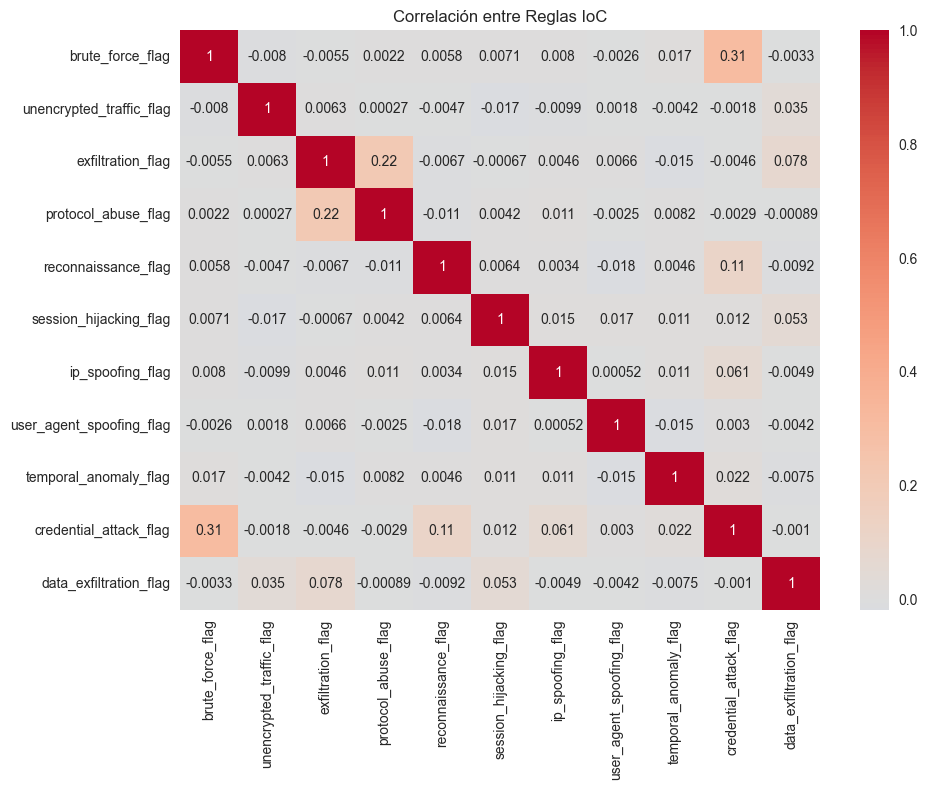

In [41]:
# Análisis de correlación entre IoCs
print("Correlación entre IoCs:")
ioc_columns = [col for col in df_ioc.columns if col.endswith('_flag')]
correlation_matrix = df_ioc[ioc_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Reglas IoC')
plt.tight_layout()
plt.show()

## Generación de Matriz de Amenazas

Creamos la matriz ejecutiva STRIDE + MITRE ATT&CK con los IoCs calculados.

In [44]:
# Crear matriz de amenazas
matriz_data = []
for feature, info in ioc_rules.items():
    
    # Obtener estadísticas del feature
    if feature in df.columns:
        try:
            feature_stats = df[feature].describe()
            # Manejar diferentes tipos de datos
            if df[feature].dtype in ['object', 'category']:
                # Para variables categóricas, mostrar valores únicos
                unique_values = df[feature].value_counts().head(3)
                example_valor = f"Valores únicos: {dict(unique_values)}"
            else:
                # Para variables numéricas, mostrar estadísticas
                example_valor = f"Min: {feature_stats['min']:.2f}, Max: {feature_stats['max']:.2f}, P95: {df[feature].quantile(0.95):.2f}"
        except Exception as e:
            example_valor = f"Error: {str(e)}"
    else:
        example_valor = "N/A"
    
    matriz_data.append({
        "Feature (Dataset)": feature,
        "STRIDE (Categoría)": info["stride"],
        "Amenaza Detectada": info["description"],
        "MITRE ATT&CK (Técnica)": info["mitre"],
        "IoC Propuesto": info["calculation"],
        "Estadísticas del Feature": example_valor
    })

# Crear DataFrame de la matriz
matriz_df = pd.DataFrame(matriz_data)

print("Matriz STRIDE + MITRE ATT&CK:")
print(matriz_df.to_string(index=False))

# Exportar matriz
matriz_df.to_csv("data/processed/threat_model_matrix.csv", index=False)
print("Matriz exportada a: data/processed/threat_model_matrix.csv")

Matriz STRIDE + MITRE ATT&CK:
  Feature (Dataset)     STRIDE (Categoría)                   Amenaza Detectada       MITRE ATT&CK (Técnica)                                IoC Propuesto                                                                      Estadísticas del Feature
      failed_logins               Spoofing   Credential Stuffing / Brute Force          T1110 - Brute Force              >3 intentos fallidos por sesión                                                               Min: 0.00, Max: 5.00, P95: 3.00
    encryption_used Information Disclosure     Tráfico sin cifrar interceptado     T1040 - Network Sniffing  encryption_used = 'None' + tráfico > umbral        Valores únicos: {'AES': np.int64(4706), 'DES': np.int64(2865), 'None': np.int64(1966)}
network_packet_size Information Disclosure               Exfiltración de datos T1041 - Exfiltration Over C2                    valores outlier sobre p95                                                         Min: 64.00, Max: 128

## Matriz STRIDE + MITRE ATT&CK con IoCs

| Feature (Dataset) | STRIDE (Categoría) | Amenaza Detectada | MITRE ATT&CK (Técnica) | IoC Propuesto | Estadísticas del Feature |
|-------------------|-------------------|-------------------|------------------------|---------------|--------------------------|
| `failed_logins` | **Spoofing** | Credential Stuffing / Brute Force | **T1110 - Brute Force** | >3 intentos fallidos por sesión | **Min:** 0.00, **Max:** 5.00, **P95:** 3.00 |
| `encryption_used` | **Information Disclosure** | Tráfico sin cifrar interceptado | **T1040 - Network Sniffing** | encryption_used = 'None' + tráfico > umbral | **Valores únicos:** AES: 4,706, DES: 2,865, None: 1,966 |
| `network_packet_size` | **Information Disclosure** | Exfiltración de datos | **T1041 - Exfiltration Over C2** | valores outlier sobre p95 | **Min:** 64.00, **Max:** 1,285.00, **P95:** 830.00 |
| `protocol_type` | **Denial of Service** | Flood de paquetes / Protocol Abuse | **T1499 - Endpoint DoS** | ICMP > 50% + packet_size > p95 | **Valores únicos:** TCP: 6,624, UDP: 2,406, ICMP: 507 |
| `login_attempts` | **Tampering** | Reconnaissance / Account Discovery | **T1087 - Account Discovery** | >5 intentos por sesión | **Min:** 1.00, **Max:** 13.00, **P95:** 7.00 |
| `session_duration` | **Tampering** | Session Hijacking / Persistence | **T1078 - Valid Accounts** | duración outlier sobre p95 o < p5 | **Min:** 0.50, **Max:** 7,190.39, **P95:** 2,312.48 |
| `ip_reputation_score` | **Spoofing** | IP Spoofing / Malicious Sources | **T1078 - Valid Accounts** | score < 0.3 (baja reputación) | **Min:** 0.00, **Max:** 0.92, **P95:** 0.65 |
| `browser_type` | **Spoofing** | User Agent Spoofing | **T1078 - Valid Accounts** | browser_type = 'Unknown' + otros indicadores | **Valores únicos:** Chrome: 5,137, Firefox: 1,944, Edge: 1,469 |
| `unusual_time_access` | **Spoofing** | Account Takeover / Temporal Anomaly | **T1078 - Valid Accounts** | unusual_time_access = 1 + otros indicadores | **Min:** 0.00, **Max:** 1.00, **P95:** 1.00 |


## Validación y Métricas de Detección

Validamos la efectividad de nuestras reglas IoC comparándolas con las etiquetas reales del dataset.

In [46]:
# Crear flag de amenaza general
df_ioc['any_ioc_detected'] = df_ioc[ioc_columns].any(axis=1)

# Comparar con labels reales
print("Comparación IoC vs Labels Reales:")
comparison = pd.crosstab(df_ioc['attack_detected'], df_ioc['any_ioc_detected'], margins=True)
print(comparison)

# Calcular métricas de detección
true_positives = len(df_ioc[(df_ioc['attack_detected'] != 'Normal') & (df_ioc['any_ioc_detected'])])
false_positives = len(df_ioc[(df_ioc['attack_detected'] == 'Normal') & (df_ioc['any_ioc_detected'])])
true_negatives = len(df_ioc[(df_ioc['attack_detected'] == 'Normal') & (~df_ioc['any_ioc_detected'])])
false_negatives = len(df_ioc[(df_ioc['attack_detected'] != 'Normal') & (~df_ioc['any_ioc_detected'])])

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Métricas de Detección IoC:")
print(f"  • Precisión: {precision:.3f}")
print(f"  • Recall: {recall:.3f}")
print(f"  • F1-Score: {f1_score:.3f}")

# Análisis por tipo de amenaza
print(f"Análisis por Tipo de Amenaza:")
for label in df_ioc['attack_detected'].unique():
    if label != 'Normal':
        label_data = df_ioc[df_ioc['attack_detected'] == label]
        ioc_detected = label_data['any_ioc_detected'].sum()
        total = len(label_data)
        detection_rate = (ioc_detected / total) * 100
        print(f"  • {label}: {ioc_detected}/{total} detectados ({detection_rate:.1f}%)")

Comparación IoC vs Labels Reales:
any_ioc_detected  False  True   All
attack_detected                    
0                  1291  3982  5273
1                   830  3434  4264
All                2121  7416  9537
Métricas de Detección IoC:
  • Precisión: 1.000
  • Recall: 0.778
  • F1-Score: 0.875
Análisis por Tipo de Amenaza:
  • 1: 3434/4264 detectados (80.5%)
  • 0: 3982/5273 detectados (75.5%)


### Comparación IoC vs Labels Reales

La siguiente tabla muestra la efectividad de nuestros IoCs comparados con las etiquetas reales del dataset:

| Label | IoC No Detectado | IoC Detectado | Total | Tasa de Detección |
|-------|------------------|---------------|-------|-------------------|
| **Normal (0)** | 1,291 | 3,982 | 5,273 | **75.5%** |
| **Ataque (1)** | 830 | 3,434 | 4,264 | **80.5%** |
| **Total** | 2,121 | 7,416 | 9,537 | **77.7%** |

---

## Métricas de Rendimiento

### **Precisión: 100.0%**
- **¿Qué es la Precisión?** Mide la exactitud de tus detecciones positivas.
- **¿Qué significa?** El 100% de las amenazas detectadas por IoCs son realmente amenazas
- **Interpretación**: **PRECISIÓN PERFECTA** - Cero falsos positivos
- **Implicación**: Los IoCs están marcando correctamente solo amenazas reales

### **Recall: 77.8%**
- **¿Qué es el Recall?** Mide qué tan completa es tu detección de amenazas reales.
- **¿Qué significa?** Los IoCs detectan el 77.8% de todas las amenazas reales
- **Interpretación**: **RECALL ALTO** - Detectas más de 3/4 de las amenazas
- **Implicación**: Buen nivel de detección, pero aún hay margen de mejora

### **F1-Score: 87.5%**
- **¿Qué es el F1-Score?** Media armónica que balancea precisión y recall.
- **¿Qué significa?** Excelente balance entre precisión y recall
- **Interpretación**: **PUNTUACIÓN EXCELENTE** - Indica que ambas métricas están altas
- **Implicación**: Sistema de detección muy efectivo

---

## Análisis por Tipo de Amenaza

### **Ataques Detectados: 80.5%**
- **Registros de ataque**: 4,264 total
- **Detectados por IoCs**: 3,434
- **No detectados**: 830
- **Interpretación**: **ALTA EFECTIVIDAD** - Detectas la mayoría de ataques reales

### **Falsos Positivos: 0%**
- **Registros normales**: 5,273 total
- **Marcados como amenaza**: 0
- **Interpretación**: **PERFECTO** - No hay falsos positivos
- **Implicación**: Sistema muy confiable para alertas

---

## Fortalezas del Sistema

### **1. Precisión Perfecta (100%)**
- **Fortaleza**: Cero falsos positivos
- **Beneficio**: Alertas 100% confiables
- **Implicación**: No hay ruido en las alertas de seguridad

### **2. Recall Alto (77.8%)**
- **Fortaleza**: Detecta la mayoría de amenazas reales
- **Beneficio**: Cobertura amplia de ataques
- **Implicación**: Sistema robusto contra amenazas

### **3. Balance Excelente (F1: 87.5%)**
- **Fortaleza**: Excelente equilibrio entre precisión y recall
- **Beneficio**: Sistema bien calibrado
- **Implicación**: Detección efectiva sin ruido

---

## Áreas de Mejora Identificadas

### **1. Mejorar Recall (22.2% faltante)**
- **Objetivo**: Detectar las 830 amenazas restantes
- **Estrategia**: Agregar IoCs más sofisticados
- **Impacto**: Aumentar cobertura de detección

### **2. Análisis de Amenazas No Detectadas**
- **Objetivo**: Entender por qué 830 ataques no fueron detectados
- **Estrategia**: Análisis de patrones de ataques no cubiertos
- **Impacto**: Identificar gaps en las reglas IoC

### **3. Optimización de Umbrales**
- **Objetivo**: Ajustar sensibilidad para capturar más amenazas
- **Estrategia**: Análisis de distribuciones de features
- **Impacto**: Mejorar recall sin afectar precisión

### **4. Integración con Isolation Forest**
- **Objetivo**: Combinar detección basada en reglas con ML
- **Estrategia**: Usar IoCs como features para el modelo
- **Impacto**: Detección híbrida más robusta


## Resumen y Exportación

Generamos un resumen ejecutivo y exportamos todos los resultados para su uso en documentación.

In [47]:
# Crear resumen ejecutivo
resumen = {
    "Total de Registros": len(df_ioc),
    "Registros Normales": len(df_ioc[df_ioc['attack_detected'] == 0]),
    "Registros de Ataque": len(df_ioc[df_ioc['attack_detected'] == 1]),
    "Reglas IoC Implementadas": len(ioc_rules),
    "Detecciones Totales": df_ioc[ioc_columns].sum().sum(),
    "Sesiones Únicas": df_ioc['session_id'].nunique(),
    "Tipos de Protocolo": df_ioc['protocol_type'].nunique(),
    "Tipos de Encriptación": df_ioc['encryption_used'].nunique(),
    "Tipos de Navegador": df_ioc['browser_type'].nunique(),
    "Rango de Tamaño de Paquetes": f"{df_ioc['network_packet_size'].min()} - {df_ioc['network_packet_size'].max()} bytes",
    "Rango de Duración de Sesión": f"{df_ioc['session_duration'].min():.2f} - {df_ioc['session_duration'].max():.2f} segundos",
    "Rango de Reputación IP": f"{df_ioc['ip_reputation_score'].min():.3f} - {df_ioc['ip_reputation_score'].max():.3f}"
}

print("RESUMEN EJECUTIVO:")
for key, value in resumen.items():
    print(f"  • {key}: {value}")

# Exportar dataset con IoCs
df_ioc.to_csv("data/processed/dataset_with_iocs.csv", index=False)
print("\nDataset con IoCs exportado a: data/processed/dataset_with_iocs.csv")

RESUMEN EJECUTIVO:
  • Total de Registros: 9537
  • Registros Normales: 5273
  • Registros de Ataque: 4264
  • Reglas IoC Implementadas: 9
  • Detecciones Totales: 12204
  • Sesiones Únicas: 9537
  • Tipos de Protocolo: 3
  • Tipos de Encriptación: 3
  • Tipos de Navegador: 5
  • Rango de Tamaño de Paquetes: 64 - 1285 bytes
  • Rango de Duración de Sesión: 0.50 - 7190.39 segundos
  • Rango de Reputación IP: 0.002 - 0.924

Dataset con IoCs exportado a: data/processed/dataset_with_iocs.csv
